In [94]:
import requests
import json
from collections import Counter
import operator
from requests.auth import HTTPBasicAuth
from datetime import datetime
import time
import re
import sys
import pandas as pd
from matplotlib import pyplot
import seaborn as sns

In [ ]:
client_id = "your_client_id"
client_secret = "your_client_secret"

In [ ]:
#find 1000 java most star repos

repos = []

for i in range(1,11):
    r = requests.get(f'https://api.github.com/search/repositories?q=language:java&sort=stars&per_page=100&page={i}&client_id={client_id}&client_secret={client_secret}')
    if(r.ok):
        res = json.loads(r.text or r.content)
    for i in res['items']:
        repos.append(i['full_name'])

with open('JavaMostStarRepos.json','w') as f:
    f.write(json.dumps(repos, indent = 4))

In [67]:
number_of_tries = 10
delay_conn = 60

def get_data(req_url):
    number_of_tries = 10
    try:   
        r = requests.get(req_url, auth=(client_id, client_secret))
        if(r.ok):            
            result = json.loads(r.text or r.content)            
            
            # check for max limit
            try:
                if int(r.headers["X-RateLimit-Remaining"]) < 10:
                    print("limit exceeded!!!!!!!!!!!!")
                    delay = float(r.headers["X-RateLimit-Reset"]) - time.mktime(time.localtime())#.total_seconds()
                    print('sleeping for '+str(delay)+' seconds...')
                    print("current time:" + str(datetime.now()))
                    time.sleep(int(delay))
            except (KeyError):
                pass 
            
            return result
        
        else:
            j = json.loads(r.text or r.content)
            print('\n---'+str(r))
            print('\n---'+str(j['message']))
            return False
    except requests.exceptions.Timeout as e:
        print(f"-------timeout for {req_url}-------")
        print(e)
        number_of_tries-=1
        if(number_of_tries):
            time.sleep(delay_conn)
            get_data(req_url)
        else:
            sys.exit(1)
    except requests.ConnectionError as e:
        print(f"-------connection for {req_url}-------")
        print(e)
        number_of_tries-=1
        if(number_of_tries):
            time.sleep(delay_conn)
            get_data(req_url)
        else:
            sys.exit(1)


def get_data_pages(req_url):    
    page_number = 1
    resp_list = [] 
    
    while(True):         
        number_of_tries = 10
        try:   
            r = requests.get(req_url + "?per_page=100&page=" + str(page_number), auth=(client_id, client_secret))            
            if(r.ok):                            
                result = json.loads(r.text or r.content)
                resp_list += result            

                if not result:
                    break
                
                if(len(result)<100):
                    break
                    
                page_number += 1
                    
                # check for max limit
                try:
                    if int(r.headers["X-RateLimit-Remaining"]) < 10:
                        print("limit exceeded!!!!!!!!!!!!")
                        delay = float(r.headers["X-RateLimit-Reset"]) - time.mktime(time.localtime())#.total_seconds()
                        print('sleeping for '+str(delay)+' seconds...')
                        print("current time:" + str(datetime.now()))
                        time.sleep(int(delay))
                except (KeyError):
                    pass            
            else:
                j = json.loads(r.text or r.content)
                print('\n---'+str(r))
                print('\n---'+str(j['message']))
                return False
        except requests.exceptions.Timeout as e:
            print(f"-------timeout for {req_url}-------")
            print(e)
            number_of_tries-=1
            if(number_of_tries):
                time.sleep(delay_conn)
                get_data_pages(req_url)
            else:
                sys.exit(1)
        except requests.ConnectionError as e:
            print(f"-------connection for {req_url}-------")
            print(e)
            number_of_tries-=1
            if(number_of_tries):
                time.sleep(delay_conn)
                get_data_pages(req_url)
            else:
                sys.exit(1)
    return resp_list

In [39]:
#find repos labels  

labels = []
for repo in repos:
    labels += get_data_pages(f'https://api.github.com/repos/{repo}/labels')
        
with open("labels.json", "w") as f:
    json.dump(labels, f, indent=4)

In [45]:
#find labels frequencies

label_names = []

for label in labels:
    label_names.append((label['name']).lower())

frequencies = dict(Counter(label_names))
sorted_frequnecies = sorted(frequencies.items(), key=operator.itemgetter(1), reverse=True)

with open("labelFrequencies.json", "w") as f:
    json.dump(dict(sorted_frequnecies), f, indent=4)

In [ ]:
#find label usage percentage

clients = [('your_clinet_id_1', 'your_clinet_secret_1'),
           ('your_clinet_id_2', 'your_clinet_secret_2'),
           ('your_clinet_id_3', 'your_clinet_secret_3'),
           ('your_clinet_id_4', 'your_clinet_secret_4'),
           ('your_clinet_id_5', 'your_clinet_secret_5')]
clients_number = len(clients)

df = pd.DataFrame()
df["repo"] = repos
all_issues = []
issues_without_label = []
index = 0
for repo in repos:
    client_id, client_secret = clients[index]
    all_issues.append(get_data(f"https://api.github.com/search/issues?q=repo:{repo}")["total_count"])
    issues_without_label.append(get_data(f"https://api.github.com/search/issues?q=repo:{repo}+no:label")["total_count"])
    index = 0 if index==clients_number-1 else index+1 
    
df["all_issues"] = all_issues
df["issues_without_label"] = issues_without_label
df["issues_with_label"] = df["all_issues"] - df["issues_without_label"]
df["label_usage_percentage"] = df["issue_with_label"] / df["all_issues"]
df.to_csv("label_usage_percentage.csv", index=False)
print(sum(issues_without_label)/sum(all_issues))

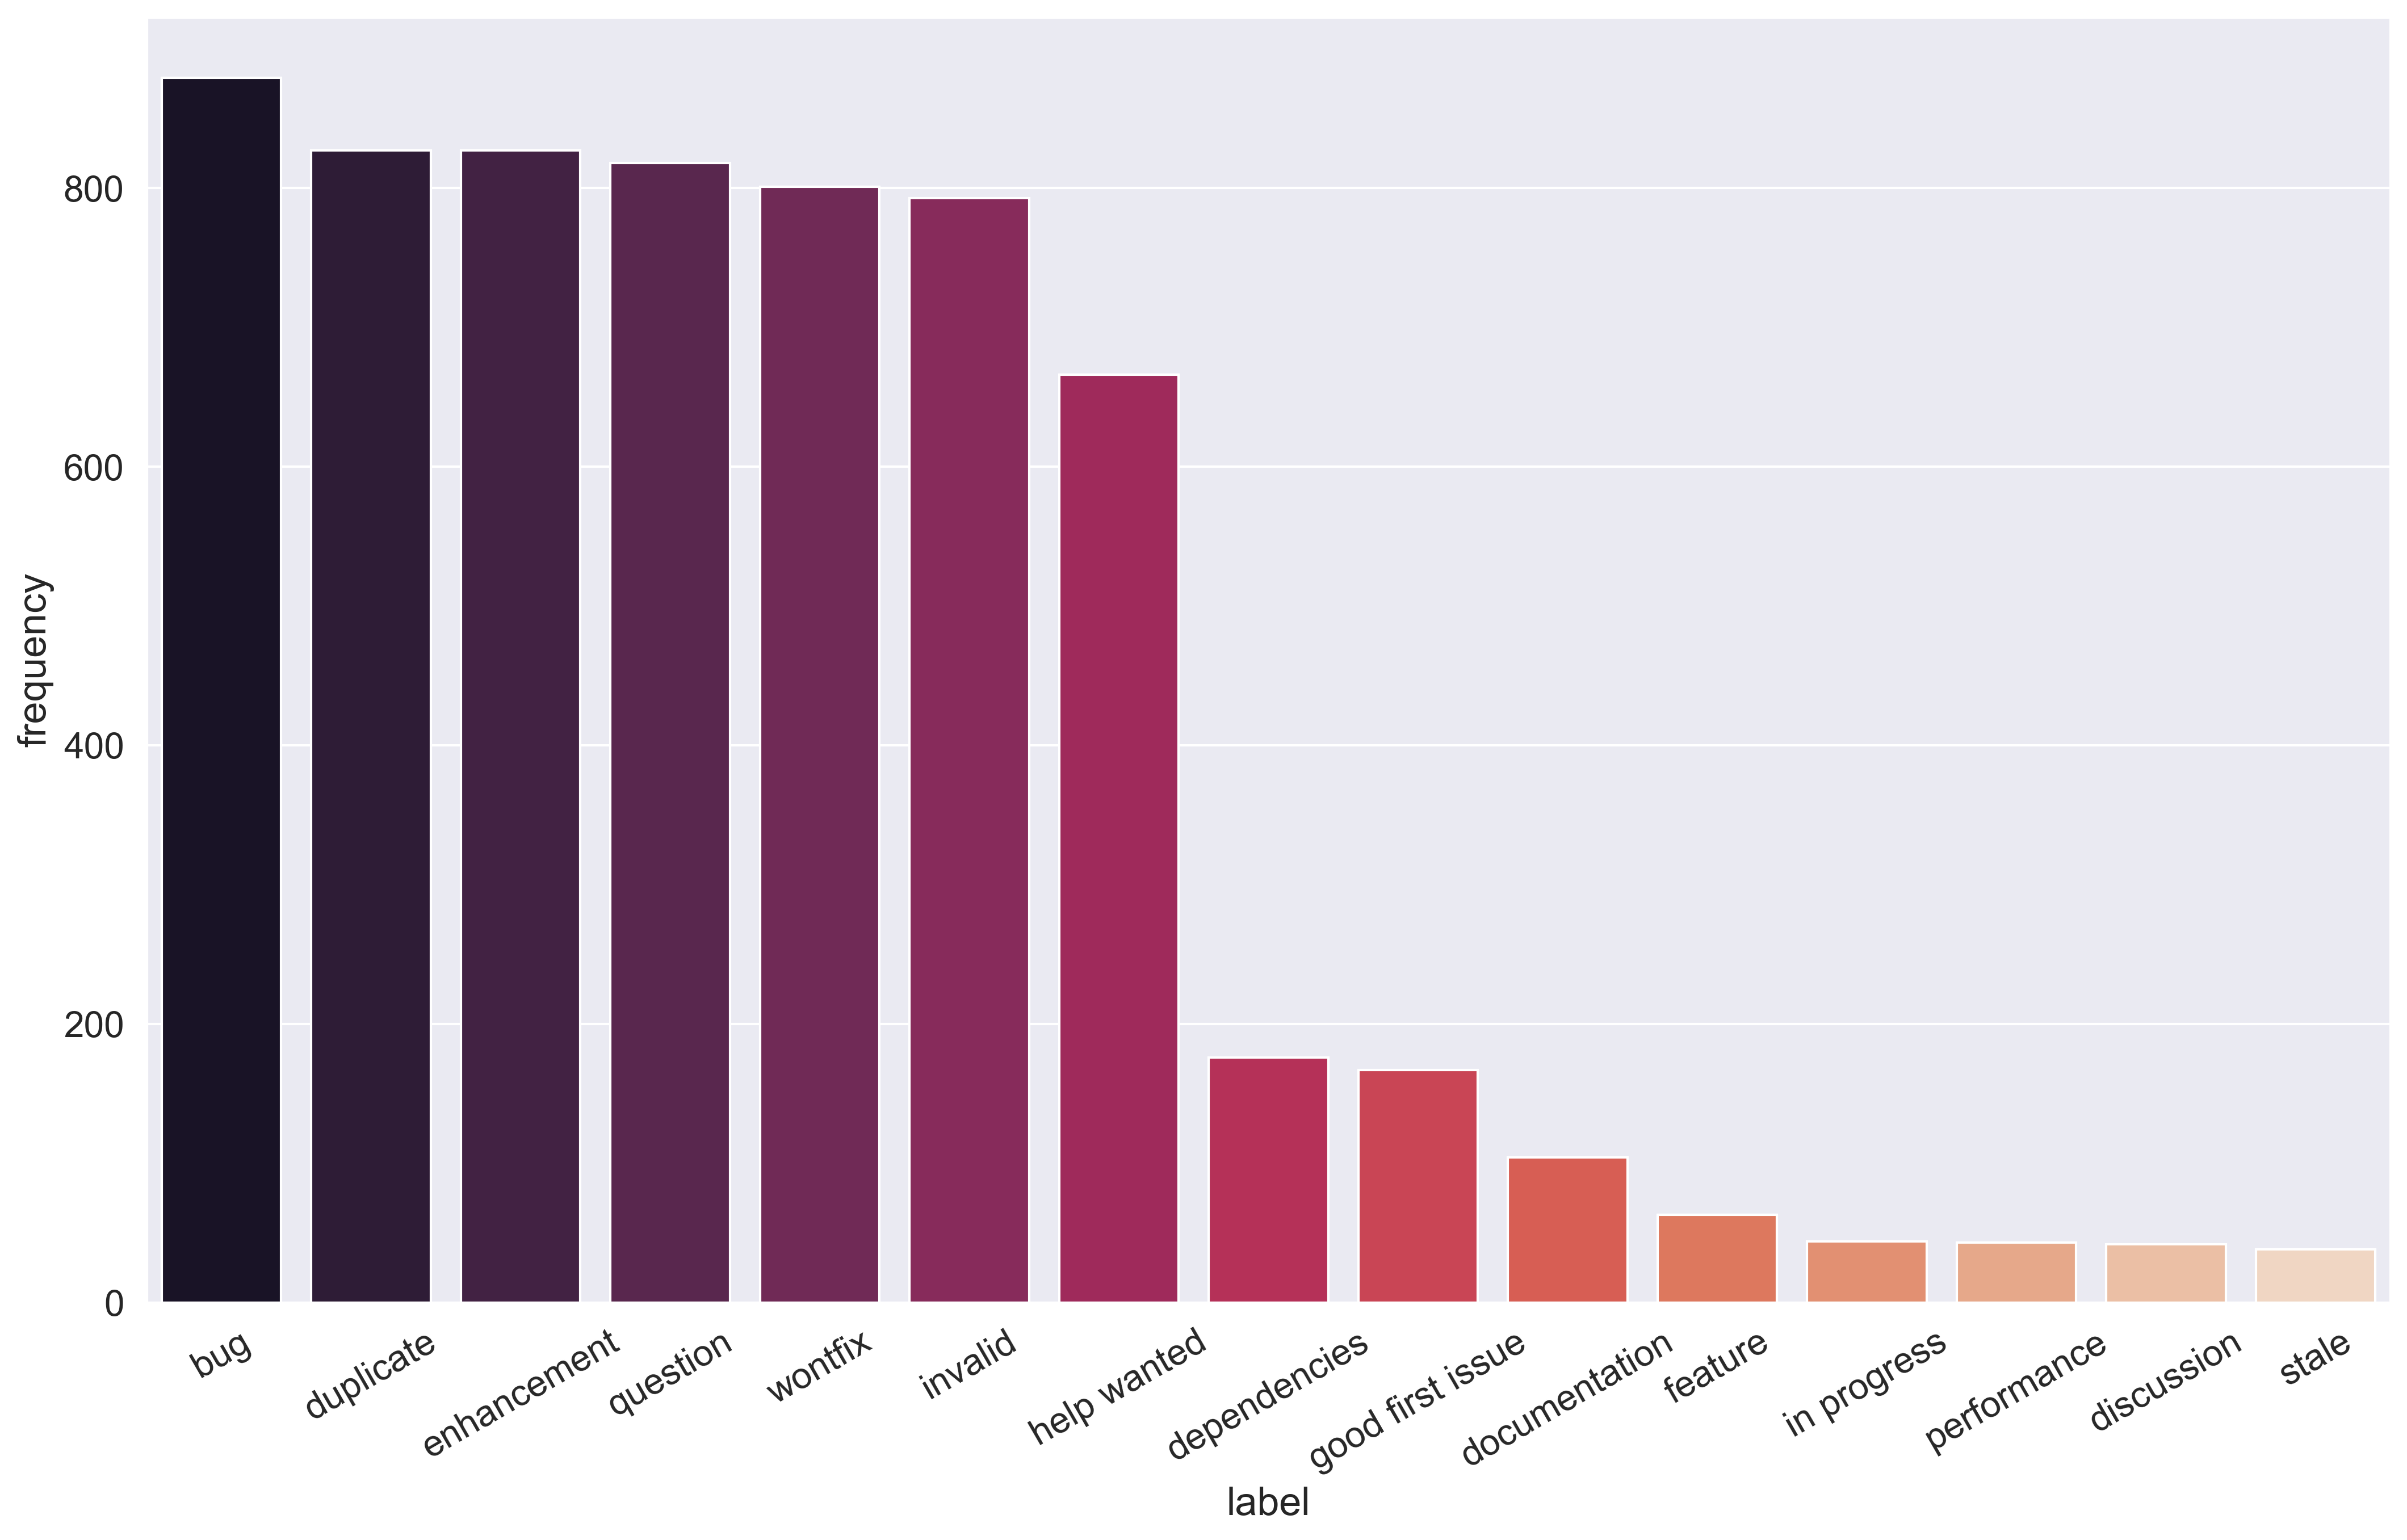

In [111]:
#visualize frequencies

d = dict(sorted_frequnecies[:15])
data = pd.DataFrame()
data["label"] = list(d.keys())
data["frequency"] = list(d.values())

sns.set(rc={'figure.figsize':(17,10)})
sns.set(font_scale = 1.4)

g = sns.barplot(x="label", y="frequency", data=data, palette="rocket")
g.set_xticklabels(g.get_xticklabels(),rotation=30)
fig = g.get_figure()
fig.set_dpi(300)

fig.savefig("output.jpeg")